# Factorization machine examples
In this notebook we train two Factorization Machines (FMs) on the California Housing dataset, such that the numerical
feature embedding vectors are defined by parametric curves. Each feature value is mapped to a point on the curve
in the embedding space. One FM is based on B-Spline curves, whereas the other on Legendre polynomial curves.

In [1]:
import math

import kagglehub as kh
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.utils.data as td
import torchcurves as tc

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

## Prepare data

In [ ]:
file_path = "housing.csv"
df = kh.dataset_load(
    kh.KaggleDatasetAdapter.PANDAS,
    "camnugent/california-housing-prices",
    file_path
)

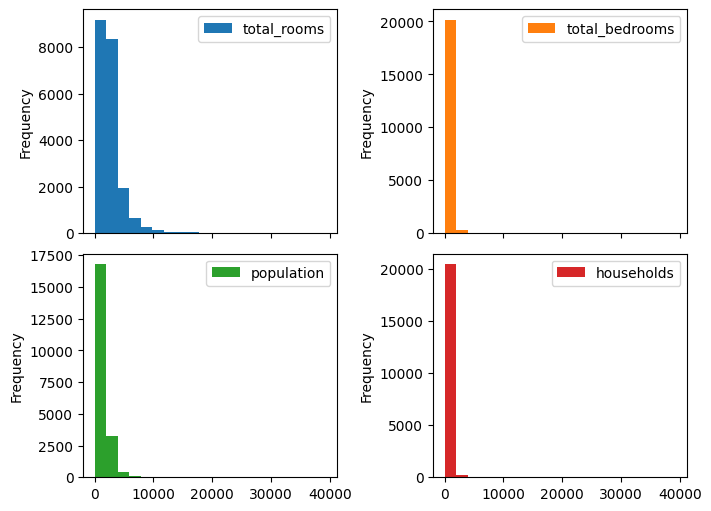

In [3]:
# columns that we know have a very skewed distribution
skewed_columns = ['total_rooms', 'total_bedrooms', 'population', 'households']
df[skewed_columns].plot.hist(
    bins=20, subplots=True, layout=(2, 2), figsize=(7, 5)
)
plt.gcf().set_layout_engine('constrained')

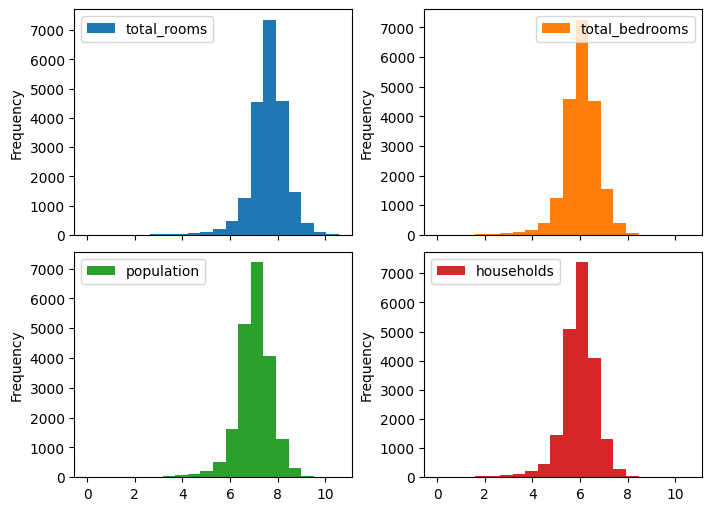

In [4]:
# apply a log1p transformation and plot the new distribution
df.loc[:, skewed_columns] = df[skewed_columns].apply(np.log)
df[skewed_columns].plot.hist(
    bins=20, subplots=True, layout=(2, 2), figsize=(7, 5)
)
plt.gcf().set_layout_engine('constrained')

In [ ]:
# define numerical, categorical, and label cols
num_cols = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income'
]
cat_cols = ['ocean_proximity']
label_col = 'median_house_value'

In [6]:
train_df = df.sample(frac=0.8, random_state=2025)
test_df = df.drop(train_df.index)

## Preprocess data

In [7]:
X_train, y_train = train_df.drop(label_col, axis=1), train_df[[label_col]]
X_test, y_test = test_df.drop(label_col, axis=1), test_df[[label_col]]

In [ ]:
feat_preprocessor = make_column_transformer(
    (OrdinalEncoder(), cat_cols),  # categorical: ordinal encode
    (make_pipeline(
        SimpleImputer(),
        StandardScaler()
     ), num_cols),                 # numerical: impute then scale
    verbose_feature_names_out=False
).set_output(transform='pandas')
label_preprocessor = StandardScaler()

In [9]:
X_train_pp = feat_preprocessor.fit_transform(X_train)
X_test_pp = feat_preprocessor.transform(X_test)

y_train_pp = label_preprocessor.fit_transform(y_train)
y_test_pp = label_preprocessor.transform(y_test)

In [10]:
X_train_cat = X_train_pp[cat_cols].values
X_train_num = X_train_pp[num_cols].values
X_test_cat = X_test_pp[cat_cols].values
X_test_num = X_test_pp[num_cols].values

In [ ]:
num_cat_features = [
    len(cats) for cats in feat_preprocessor['ordinalencoder'].categories_
]

## Train and evaluate models

### Define modules

In [ ]:
class FM(nn.Module):
    """Base class for factorization machine modules with numerical embeddings.

    Args
        num_cont_features (int): the number of continuous numerical features.
            Each feature is associated with a curve in the embedding space.
        num_cat_features (list[int]): The number of categorical features in each
            categorical field. Each categorical feature has its
            own embedding vector.
        emb_dim (int): the dimension of the factorization machine embedding
            vectors.
        num_emb_ctor (Callable[int, int, **kwargs]): a function that constructs
            the curve objects that serve as the numerical embeddings. We will
            use this flexibility to test both Legendre and Spline embeddings.
        num_emb_kwargs (dict): keyword arguments to pass to ``num_emb_ctor``.
    """
    def __init__(self, num_cont_features, num_cat_features, emb_dim, num_emb_ctor, num_emb_kwargs):
        super().__init__()
        self.bias = nn.Parameter(torch.tensor(0.))

        # continuous features represented by curves
        self.pwise_cont_emb = num_emb_ctor(
            num_cont_features, emb_dim, **num_emb_kwargs
        )
        self.linear_cont_emb = num_emb_ctor(
            num_cont_features, 1, **num_emb_kwargs
        )

        # categorical features represented by regular embeddings
        total_num_cat_features = sum(num_cat_features)
        self.pwise_cat_emb = nn.Embedding(total_num_cat_features, emb_dim)
        self.linear_cat_emb = nn.Embedding(total_num_cat_features, 1)

        # assume categorical features are ordinally-encoded for each column
        # separately, so to index one big embedding table we need an offset
        # per column.
        cat_feature_offsets = torch.cumsum(
            torch.as_tensor([0, *num_cat_features]), dim=-1
        )
        cat_feature_offsets = cat_feature_offsets[:-1]
        self.register_buffer("cat_feature_offsets", cat_feature_offsets)

    def forward(self, num, cat):
        # get embeddings and linear terms for numerical features
        num_emb = self.pwise_cont_emb(num)
        num_lin = self.linear_cont_emb(num)

        # get embeddings and linear term for categorical features
        offset_cat = cat + self.cat_feature_offsets
        cat_emb = self.pwise_cat_emb(offset_cat)
        cat_lin = self.linear_cat_emb(offset_cat)

        # compute pairwise interactions between all embeddings using
        # the square_of_sum - sum_of_square trick from the FM paper
        # by Rendle et. al. (2010).
        emb = torch.cat((num_emb, cat_emb), axis=-2)
        sum_of_sq = emb.square().sum(dim=(-2, -1))
        sq_of_sum = emb.sum(dim=(-2, -1)).square()
        pairwise_term = (sq_of_sum - sum_of_sq) / 2.

        # compute the linear term for both categorical and numerical features
        linear_term = num_lin.sum(dim=(-2, -1)) + cat_lin.sum(dim=(-2, -1))

        return pairwise_term + linear_term + self.bias

In [ ]:
class BSplineFM(FM):
    """An FM with rationally-normalized B-Spline embeddings"""
    def __init__(
            self, num_cont_features, num_cat_features, emb_dim, num_coefs=10
    ):
        super().__init__(
            num_cont_features, num_cat_features, emb_dim,
            tc.BSplineEmbeddings,
            num_emb_kwargs=dict(knots_config=num_coefs, normalize_fn='rational')
        )


class LegendreFM(FM):
    """An FM with rationally-normalized Legendre curve embeddings"""
    def __init__(
            self, num_cont_features, num_cat_features, emb_dim, num_coefs=10
    ):
        super().__init__(
            num_cont_features, num_cat_features, emb_dim,
            tc.LegendreCurve,
            num_emb_kwargs=dict(degree=num_coefs - 1, normalize_fn='rational')
        )


### Model training logic

In [14]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [15]:
train_ds = td.TensorDataset(
        torch.as_tensor(X_train_num, dtype=torch.float32),
        torch.as_tensor(X_train_cat, dtype=torch.int32),
        torch.as_tensor(y_train_pp, dtype=torch.float32)
    )
eval_ds = td.TensorDataset(
        torch.as_tensor(X_test_num, dtype=torch.float32),
        torch.as_tensor(X_test_cat, dtype=torch.int32),
        torch.as_tensor(y_test_pp, dtype=torch.float32)
    )

In [ ]:
# we aren't tuning hyperparameters for each model, so we're conservative - many
# epochs with a small step-size
num_epochs = 200
lr = 1e-4

print_every = 25  # print progress every N epochs
emb_dim = 10      # factorization machine embedding dimension
batch_size = 32   # training batch size

train_set_size = len(X_train_pp)
test_set_size = len(X_test_pp)

In [ ]:
def train_epoch(model, optim, criterion, train_dl):
    """A pretty standard PyTorch training epoch."""
    tr_loss = 0.
    for xnum, xcat, yb in train_dl:
        xnum = xnum.to(device)
        xcat = xcat.to(device)
        yb = yb.to(device)

        pred = model(xnum, xcat)
        loss = criterion(yb.squeeze(), pred)

        optim.zero_grad()
        loss.backward()
        optim.step()

        tr_loss += loss * torch.numel(yb)
    return tr_loss.item() / train_set_size


@torch.no_grad
def eval_epoch(model, eval_criterion, eval_dl):
    """A pretty standard evaluation epoch.

    Scales the model's output to the original unit to compute RMSE in terms
    of dollars, instead of in terms of standardized labels.
    """
    eval_total_error = 0.
    for xnum, xcat, yb in eval_dl:
        # predict
        pred = model(xnum.to(device), xcat.to(device))

        # compute label and prediction in terms of dollars
        label_orig = label_preprocessor.inverse_transform(yb.view(-1, 1))
        pred_orig = label_preprocessor.inverse_transform(pred.cpu().view(-1, 1))

        # compute loss on the original labels
        loss = eval_criterion(
            torch.as_tensor(label_orig, device=device, dtype=torch.float32),
            torch.as_tensor(pred_orig, device=device, dtype=torch.float32)
        )
        eval_total_error += loss * torch.numel(yb)
    return eval_total_error.item() / test_set_size

In [ ]:
def train_eval_model(
        name, model: nn.Module, batch_size: int,
        print_progress=True, **optim_kwargs
):
    """A pretty standard training loop with several epochs."""
    model = model.to(device)
    optim = torch.optim.AdamW(model.parameters(), **optim_kwargs)
    criterion = nn.MSELoss()
    train_dl = td.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    eval_dl = td.DataLoader(eval_ds, batch_size=128)

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, optim, criterion, train_dl)
        eval_loss = eval_epoch(model, criterion, eval_dl)
        eval_rmse = math.sqrt(eval_loss)
        if print_progress and (epoch % print_every == 0 or epoch == num_epochs):
            print(f'[{name}] Epoch {epoch}, tr loss = {train_loss:.4f}, eval RMSE = {eval_rmse:.2f}')

    return model

### Run experiments

In [19]:
bspline_model = train_eval_model(
    "BSpline",
    BSplineFM(len(num_cols), num_cat_features, emb_dim),
    lr=lr, weight_decay=1e-6, batch_size=batch_size
)


[BSpline] Epoch 25, tr loss = 0.3374, eval RMSE = 65255.03
[BSpline] Epoch 50, tr loss = 0.2875, eval RMSE = 60537.46
[BSpline] Epoch 75, tr loss = 0.2725, eval RMSE = 58753.24
[BSpline] Epoch 100, tr loss = 0.2656, eval RMSE = 58215.58
[BSpline] Epoch 125, tr loss = 0.2621, eval RMSE = 57946.09
[BSpline] Epoch 150, tr loss = 0.2600, eval RMSE = 57465.78
[BSpline] Epoch 175, tr loss = 0.2579, eval RMSE = 57315.65
[BSpline] Epoch 200, tr loss = 0.2575, eval RMSE = 57380.79


In [20]:
hires_bspline_model = train_eval_model(
    "BSpline-HiRes",
    BSplineFM(len(num_cols), num_cat_features, emb_dim, num_coefs=50),
    lr=lr, weight_decay=1e-7, batch_size=batch_size
)

[BSpline-HiRes] Epoch 25, tr loss = 0.2431, eval RMSE = 56348.62
[BSpline-HiRes] Epoch 50, tr loss = 0.2339, eval RMSE = 55362.70
[BSpline-HiRes] Epoch 75, tr loss = 0.2306, eval RMSE = 55056.06
[BSpline-HiRes] Epoch 100, tr loss = 0.2281, eval RMSE = 54738.12
[BSpline-HiRes] Epoch 125, tr loss = 0.2260, eval RMSE = 54813.38
[BSpline-HiRes] Epoch 150, tr loss = 0.2243, eval RMSE = 54344.59
[BSpline-HiRes] Epoch 175, tr loss = 0.2220, eval RMSE = 54099.03
[BSpline-HiRes] Epoch 200, tr loss = 0.2210, eval RMSE = 54119.49


In [21]:
legendre_model = train_eval_model(
    "Legendre",
    LegendreFM(len(num_cols), num_cat_features, emb_dim),
    lr=lr, weight_decay=1e-6, batch_size=batch_size
)

[Legendre] Epoch 25, tr loss = 0.3430, eval RMSE = 66058.28
[Legendre] Epoch 50, tr loss = 0.3027, eval RMSE = 62573.25
[Legendre] Epoch 75, tr loss = 0.2913, eval RMSE = 61324.00
[Legendre] Epoch 100, tr loss = 0.2861, eval RMSE = 61328.21
[Legendre] Epoch 125, tr loss = 0.2827, eval RMSE = 60917.52
[Legendre] Epoch 150, tr loss = 0.2805, eval RMSE = 60259.45
[Legendre] Epoch 175, tr loss = 0.2793, eval RMSE = 59873.15
[Legendre] Epoch 200, tr loss = 0.2772, eval RMSE = 59626.57


In [22]:
highdeg_legendre_model = train_eval_model(
    "Legendre-HiDeg",
    LegendreFM(len(num_cols), num_cat_features, emb_dim, num_coefs=50),
     lr=lr, weight_decay=1e-7, batch_size=batch_size
)

[Legendre-HiDeg] Epoch 25, tr loss = 0.2657, eval RMSE = 58489.69
[Legendre-HiDeg] Epoch 50, tr loss = 0.2487, eval RMSE = 57528.51
[Legendre-HiDeg] Epoch 75, tr loss = 0.2416, eval RMSE = 56298.05
[Legendre-HiDeg] Epoch 100, tr loss = 0.2359, eval RMSE = 55578.51
[Legendre-HiDeg] Epoch 125, tr loss = 0.2302, eval RMSE = 55286.54
[Legendre-HiDeg] Epoch 150, tr loss = 0.2260, eval RMSE = 55000.92
[Legendre-HiDeg] Epoch 175, tr loss = 0.2197, eval RMSE = 54133.51
[Legendre-HiDeg] Epoch 200, tr loss = 0.2135, eval RMSE = 53880.56
